# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, October 2020

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [3]:
G = {
    "BreastDensity" : ['Mass'],
    "Location" : ['BC'],
    "Age" : ['BC'],
    "BC" : ['MC','SkinRetract','NippleDischarge','AD','Mass','Metastasis'],
    "Mass" : ['Size','Shape','Margin'],
    "AD" : ['FibrTissueDev'],
    "Metastasis" : ['LymphNodes'],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ['Spiculation', 'SkinRetract', 'NippleDischarge'],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ['Margin'],
    "Margin" : [],
}

In [4]:
# G: node --> child graph
# G_p: node --> parent graph
def find_parents(G):
    G_p={}
    for node in G:
        G_p[node]=[]
    for node in G:
        for c_node in G[node]:
            G_p[c_node].append(node)
    return G_p

In [5]:
#G_p = find_parents(G)

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: true if **X** is d-separated from **Y** given **Z** in the graph $G$ and false otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a graph as defined in tutorial 1.

In [6]:
# Develop your code for d_separation(G, X, Z, Y) in one or more cells here

In [7]:
# Using bfs to find whether there is a way from X to Y
# G is a no direction graph. Both current node's parents and children need to be added in.

def BFS(G, G_p, X, Y):
    searched = []
    while True:
        if not X:
            break
        x_node=X.pop()
        searched.append(x_node)
        if x_node in Y:
            return False
        else:
            for node in G[x_node]:
                if node not in searched:
                    X.append(node)
            for node in G_p[x_node]:
                if node not in searched:
                    X.append(node)
    return True

In [8]:
def d_separation(G, X, Z, Y):
    
    G_p=find_parents(G)
    
    # Generate a new DAG G_new
    G_new={}
    
    # Find all leaf nodes from G if they are not belong to X, Y and Z
    leaf_nodes=[]
    for val in G:
        if not G[val] and val not in X and val not in Y and val not in Z:
            leaf_nodes.append(val)
    
    # Delete all leaf nodes
    # Delete all edges outgoing from nodes in Z
    
    for val in G:
        if val not in leaf_nodes:
            G_new[val]=[]
            if val in Z:
                pass
            else:
                for value in G[val]:
                    if value not in leaf_nodes:
                        G_new[val].append(value)
        
    return BFS(G_new, G_p, list(X), list(Y))

In [9]:
############
## TEST CODE

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','LymphNodes']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a function ``learn_bayes_net(G, data, outcomeSpace)`` that learns the parameters of the Bayesian Network $G$. This function should return a dictionary ``prob_tables`` with the all conditional probability tables (one for each node).

- ``G`` is a directed acyclic graph. For this part of the assignment, $G$ should be declared according to the breast cancer Bayesian network presented in the diagram in the assignment specification.
- ``data`` is a dataframe created from a csv file containing the relevant data. 
- ``outcomeSpace`` is defined in tutorials.
- ``prob_tables`` is a dict from each variable name (node) to a "factor". Factors are defined in tutorial 2. 

In [10]:
## Develop your code for learn_outcome_space(data) in one or more cells here

In [11]:
def learn_outcome_space(data):
    head_name=list(data.columns)
    outcomspace={}
    for var in head_name:
        outcomspace[var]=set(data[var])
    return outcomspace

In [12]:
############
## TEST CODE

with open('bc.csv') as file:
    data = pd.read_csv(file)

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [13]:
## Develop your code for learn_bayes_net(G, data, outcomeSpace) in one or more cells here

In [14]:
def condition_prob(node, G_p, data):
    
    # find nodes in factor
    world = [node]+G_p[node]
    df = pd.DataFrame(data.groupby(world).size(), columns=['num'])
    
    # if the node has no parents
    if not G_p[node]:
        df['num'] = df['num']/df['num'].sum()
        d = {}
        d['dom'] = tuple(df.index.names)
        d['table'] = odict()
        for x in df.index:
            x_1 = (x, )
            d['table'][x_1] = df.loc[x, 'num']
            
    # if the node have parents
    else:
        d = {}
        d['table'] = odict()
        df2 = df.sum(level=G_p[node])
        df3 = pd.merge(df, df2, left_index=True, right_index=True)
        df3['num']=df3['num_x']/df3['num_y']
        d['dom'] = tuple(df3.index.names)
        for x in df3.index:
            d['table'][x] = df3.loc[x, 'num']

    return  d

In [15]:
def learn_bayes_net(G, data, outcomeSpace):
    G_p = find_parents(G)
    prob_tables = {}
    for node in G:
        d = condition_prob(node, G_p, data)
        prob_tables[node] = d
    return prob_tables

In [16]:
############
## TEST CODE

prob_tables = learn_bayes_net(G, data, outcomeSpace)
test(abs(prob_tables['Age']['table'][('35-49',)] - 0.2476) < 0.001)

Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)`` that uses the test cases in ``data`` to assess the performance of the Bayesian network defined by ``G`` and ``prob_tables``. Implement the efficient classification procedure discussed in the lectures. Such a function should return the classifier accuracy. 
 * ``class_var`` is the name of the variable you are predicting, using all other variables.
 * ``outcomeSpace`` was created in task 2
 
Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Return just the accuracy:

``acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)``

In [17]:
# remove the variables metastasis and lymphnodes from G

In [18]:
import copy

In [19]:
# new G
def G_remove(G, remove_list):
    G_r = copy.deepcopy(G)
    for x in G:
        if x in remove_list:
            G_r.pop(x)
        else:
            for y in G[x]:
                if y in remove_list:
                    G_r[x].remove(y)
    return G_r

In [20]:
# new outcomespace
def outcomeSpace_remove(outcomeSpace, remove_list):
    outcomeSpace_r = outcomeSpace.copy()
    for node in outcomeSpace:
        if node in remove_list:
            outcomeSpace_r.pop(node)
    return outcomeSpace_r

In [21]:
# new data
def data_remove(data, remove_list):
    data_r =copy.deepcopy(data)
    for x in remove_list:
        if x in list(data.columns):
            data_r.drop(columns=x, inplace=True)
    return data_r

In [22]:
# remove 'Metastasis' and 'LymphNodes' 
remove_list = ['Metastasis','LymphNodes']
G = G_remove(G, remove_list)
outcomeSpace = outcomeSpace_remove(outcomeSpace, remove_list)
data = data_remove(data, remove_list)

In [23]:
# Develop your code for assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

In [24]:
# prob and join functions are from tutorial 2

In [25]:
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """
    if entry in factor['table']:
        return factor['table'][entry]
    return 0     # insert your code here, 1 line    

In [26]:
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

In [27]:
# find Markov blanket
# return {'parent': parent, 'child': child, 'spouse': spouse, 'node': current_node}

def find_M_blanket(G, G_p, class_var):
    blanket = {}
    blanket['node'] = [class_var]
    
    # add children and parents
    blanket['child'] = G[class_var]
    blanket['parent'] = G_p[class_var]
    
    # add spouses
    spouses = []
    for node in G[class_var]:
            spouses = spouses + G_p[node]
    blanket['spouse'] = list(set(spouses))
    blanket['spouse'].remove(class_var)
    
    return blanket

In [28]:
# Generate joint table of all nodes in M_blanket

def all_world(train_net, outcomeSpace, M_blanket):
    join_order = []
    # from children but not spouses
    for child in M_blanket['child']:
        if child not in M_blanket['spouse']:
            join_order.append(child)
    
    # node
    join_order.append(M_blanket['node'][0])
    
    # spouses
    for spouse in M_blanket['spouse']:
        join_order.append(spouse)
    
    # parents
    for parents in M_blanket['parent']:
        join_order.append(parents)
    
    # join all nodes in order
    if len(join_order)<2:
        return train_net
    else:
        prob_table = train_net[join_order[0]]
        for i in range(1, len(join_order)):
            prob_table = join(prob_table, train_net[join_order[i]], outcomeSpace)
            
    return prob_table

In [29]:
def predict(evidence, joint_table, class_var, outcomeSpace):
    all_v = list(outcomeSpace[class_var])
    res = all_v[0]
    p = 0
    for x in all_v:
        evidence[class_var] = x
        temp = joint_table['table'][tuple(evidence)]
        if temp > p:
            res = x
            p = temp
    return res

In [30]:
def predict_acc(class_var, e, prob_table, outcomeSpace):
    i = 0
    j = 0
    for n in range(len(e)):
        t = e.iloc[n].copy(deep = True)
        if predict(t, prob_table, class_var, outcomeSpace)==e[class_var][n]:
            i = i + 1
        else:
            j = j + 1
    return i/(i+j)

In [31]:
def assess_bayes_net(G, prob_tables, test_df, outcomeSpace, class_var):
    G_p = find_parents(G)
    M_blanket = find_M_blanket(G, G_p, class_var)
    joint_table = all_world(prob_tables, outcomeSpace, M_blanket)
    e = test_df[list(joint_table['dom'])]
    return predict_acc(class_var, e, joint_table, outcomeSpace)

In [32]:
############
## TEST CODE
# removed nodes
k = 10
l = len(data)
n = 0
test_data = data.iloc[n*l//k:(n+1)*l//k]
train_data = data.drop(data.index[n*l//k:(n+1)*l//k])
test_data = test_data.reset_index(drop = True)


train_prob_tables = learn_bayes_net(G, train_data, outcomeSpace)

#acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)
assess_bayes_net(G, train_prob_tables, test_data, outcomeSpace, 'BC')

0.8395

Develop a function ``cv_bayes_net(G, data, class_var)`` that uses ``learn_outcome_space``, ``learn_bayes_net``and ``assess_bayes_net`` to learn and assess a Bayesian network in a dataset using 10-fold cross-validation. Compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation, e.g.

``acc, stddev = cv_bayes_net(G, data, class_var)``

In [33]:
## Develop your code for cv_bayes_net(G, data, class_var) in one or more cells here

In [34]:
def cv_bayes_net(G, data, class_var):
    
    acc_list = []
    
    k = 10
    l = len(data)
    
    for n in range(k):
    
        # split train and test data sets
        test_data = data.iloc[n*l//k:(n+1)*l//k]
        train_data = data.drop(data.index[n*l//k:(n+1)*l//k])
        test_data = test_data.reset_index(drop = True)

        train_prob_tables = learn_bayes_net(G, train_data, outcomeSpace)
        
        acc_list.append(assess_bayes_net(G, train_prob_tables, test_data, outcomeSpace, class_var))
        
    acc_Series = pd.Series(acc_list)
    
    return acc_Series.mean(), acc_Series.std()

In [35]:
############
## TEST CODE
# removed
acc, stddev = cv_bayes_net(G, data, 'BC')
acc, stddev

(0.8411, 0.006208417225383976)

## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to classify and assess the test cases in a dataset ``data`` according to the Naïve Bayes classifier. To classify each example, use the log probability trick discussed in the lectures. This function should return the accuracy of the classifier in ``data``.

In [36]:
## Develop your code for assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

In [37]:
def assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var):
    i = 0
    for n in range(len(data)):
        evidence = data.iloc[n]
        res = predict_naive(evidence, prob_tables, class_var)
        if res == evidence[class_var]:
            i = i + 1
    return i/len(data)

In [46]:
############
## TEST CODE

#  please compile all functions in this task first

k = 10
l = len(data)
n = 0
G_p = find_parents(G)
test_data = data.iloc[n*l//k:(n+1)*l//k]
train_data = data.drop(data.index[n*l//k:(n+1)*l//k])
test_data = test_data.reset_index(drop = True)

naive_graph = learn_naive_bayes_structure(outcomeSpace, 'BC')
naive_net = learn_bayes_net(naive_graph, train_data, outcomeSpace)



acc = assess_naive_bayes(naive_graph, naive_net, test_data, outcomeSpace, 'BC')
acc

0.7875

Develop a new function ``cv_naive_bayes(data, class_var)`` that uses ``assess_naive_bayes`` to assess the performance of the Naïve Bayes classifier in a dataset ``data``. To develop this code, perform the following steps:

1. Use 10-fold cross-validation to split the data into training and test sets.

2. Implement a function ``learn_naive_bayes_structure(outcomeSpace, class_var)`` to create and return a Naïve Bayes graph structure from ``outcomeSpace`` and ``class_var``. 

3. Use ``learn_bayes_net(G, data, outcomeSpace)`` to learn the Naïve Bayes parameters from a training set ``data``. 

4. Use ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to compute the accuracy of the Naïve Bayes classifier in a test set ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Do 10-fold cross-validation, same as above, and return ``acc`` and ``stddev``.

In [ ]:
## Develop your code for learn_naive_bayes_structure(outcomeSpace, class_var) in one or more cells here

In [39]:
def learn_naive_bayes_structure(outcomeSpace, class_var):
    naive_G = {}
    naive_G[class_var] = []
    for node in outcomeSpace:
        if node != class_var:
            naive_G[class_var].append(node)
            naive_G[node] = []
    return naive_G

In [40]:
############
## TEST CODE

naive_graph = learn_naive_bayes_structure(outcomeSpace, 'BC')
#naive_graph

In [41]:
def predict_naive(evidence, naive_net, class_var):
    post = {}
    for prior in naive_net[class_var]['table']:
        posterior = 0
        for node in naive_net:
                if node == class_var:
                    posterior = posterior + math.log(naive_net[class_var]['table'][prior])
                else:
                    likelihood = tuple()
                    for x in naive_net[node]['dom']:
                        if x == class_var:
                            likelihood = likelihood + prior
                        else:
                            likelihood = likelihood + (evidence[x], )
                    try:
                        posterior = posterior + math.log(naive_net[node]['table'][likelihood])
                    except KeyError:
                        posterior = posterior + math.log(1/20000)
                    else:
                        pass
        post[prior] = posterior
    return max(zip(post.values(),post.keys()))[1][0]

In [42]:
## Develop your code for cv_naive_bayes(data, class_var) in one or more cells here

In [43]:
def cv_naive_bayes(data, class_var):
    outcomeSpace = learn_outcome_space(data)
    naive_graph = learn_naive_bayes_structure(outcomeSpace, class_var)
    

    acc_list = []
    
    k = 10
    l = len(data)
    
    for n in range(k):
    
        # split train and test data sets
        test_data = data.iloc[n*l//k:(n+1)*l//k]
        train_data = data.drop(data.index[n*l//k:(n+1)*l//k])
        test_data = test_data.reset_index(drop = True)
        
        naive_net = learn_bayes_net(naive_graph, train_data, outcomeSpace)
        
        acc_list.append(assess_naive_bayes(naive_graph, naive_net, test_data, outcomeSpace, class_var))
        
    acc_Series = pd.Series(acc_list)
    
    return acc_Series.mean(), acc_Series.std()

In [44]:
############
## TEST CODE

acc, stddev = cv_naive_bayes(data, 'BC')

In [45]:
acc, stddev

(0.7919, 0.009103723292026066)

## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, outcomeSpace, class_var)`` to learn the TAN structure (graph) from the ``data`` and returns such a structure.

In [47]:
## Develop your code for learn_tan_structure(data, outcomeSpace, class_var) in one or more cells here

In [ ]:
# Get the results for P(𝐴𝑖|C)
# In this case, all attributs 

In [48]:
def TAN_condition_prob(node, data, class_var):
    world = [node] + [class_var]
    df = pd.DataFrame(data.groupby(world).size(), columns=['num'])

    d = {}
    d['table'] = odict()
    df2 = df.sum(level=class_var)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    df3['num']=df3['num_x']/df3['num_y']
    d['dom'] = tuple(df3.index.names)
    for x in df3.index:
        d['table'][x] = df3.loc[x, 'num']
    
    return  d

In [49]:
#TAN_condition_prob('Age', data, 'BC')

In [50]:
def TAN_con_table(outcomeSpace, data, class_var): 
    con_tables = {}
    for node in outcomeSpace:
        if node != class_var:
            d = TAN_condition_prob(node,data, class_var)
            con_tables[node] = d
    return con_tables

In [51]:
#TAN_con_table(outcomeSpace, data, 'BC').keys()

In [ ]:
# Get the probability P(𝐴𝑖, 𝐴𝑗|C) for each two attributes

In [52]:
def TAN_join_condition_prob(node_i, node_j, data, class_var):
    world = [node_i] + [node_j] + [class_var]
    df = pd.DataFrame(data.groupby(world).size(), columns=['num'])
    
    d = {}
    d['table'] = odict()
    df2 = df.sum(level=class_var)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    df3['num']=df3['num_x']/df3['num_y']
    d['dom'] = tuple(df3.index.names)
    for x in df3.index:
        d['table'][x] = df3.loc[x, 'num']
    
    return  d

In [53]:
def join_con_table(outcomeSpace, data, class_var): 
    con_tables = {}
    for node_i in outcomeSpace:
        for node_j in outcomeSpace:
            if node_i != class_var and node_j != class_var and node_i != node_j:
                d = TAN_join_condition_prob(node_i, node_j, data, class_var)
                con_tables[(node_i, node_j)] = d
    return con_tables

In [54]:
#jct = join_con_table(outcomeSpace, data, 'BC')

In [ ]:
# Calculate the probability of each value of the class variable

In [56]:
def prob_class(data, outcomeSpace, class_var):
    var = outcomeSpace
    copy_data=data.copy()
    prob_class={}
    for v in var[class_var]:
        v_data = copy_data.loc[copy_data[class_var]==v]
        prob_class[v] = len(v_data)/len(copy_data)
    return prob_class

In [ ]:
# Get the probability P(𝐴𝑖,𝐴𝑗,C) for each two attributes 
# Using P(𝐴𝑖,𝐴𝑗,C) = P(𝐴𝑖,𝐴𝑗|C)*P(C) to get the probability

In [59]:
def TAN_join_prob(data, outcomeSpace, join_prob, class_var):
    var = outcomeSpace
    join_res = {}
    #join_prob = join_con_table(outcomeSpace, data, class_var)
    class_var_prob = pd.DataFrame(data.groupby('BC').size()/len(data), columns=['num']).to_dict()['num']
    for k in join_prob.keys():
        for key in join_prob[k]['table'].keys():
            for v in var[class_var]:
                if v in key:
                    join_res[key] = join_prob[k]['table'][key] * class_var_prob[v]
    return join_res

In [ ]:
# Get the mutual information for every two attributes

In [60]:
def MI_TAN(data, outcomeSpace, class_var):
    MI = {}
    prob_aic = TAN_con_table(outcomeSpace, data, class_var)
    prob_con_aiajc = join_con_table(outcomeSpace, data, class_var)
    prob_join_aiajc = TAN_join_prob(data, outcomeSpace, prob_con_aiajc, class_var)
    for i in outcomeSpace:
        for j in outcomeSpace:
            sum_MI = 0
            if i != j and i != class_var and j != class_var:                
                s = prob_con_aiajc[(i, j)]['table'].keys()
                l = prob_aic[i]['table'].keys()
                r = prob_aic[j]['table'].keys()
                u = prob_join_aiajc.keys()
                for v1 in l:
                    for v2 in r:
                        for v in s:
                            if v1[0] == v[0] and v2[0] == v[1] and v1[1] == v2[1] and v1[1] == v[2]:
                                ai = prob_aic[i]['table'][(v1[0], v1[1])]
                                aj = prob_aic[j]['table'][(v2[0], v1[1])]
                                aiaj = prob_con_aiajc[(i, j)]['table'][(v[0], v[1], v[2])]
                                aiajc = prob_join_aiajc[(v[0], v[1], v[2])]
                                
                                temp = aiaj / (ai * aj)
                                t = math.log(temp) * aiajc
                sum_MI += t
                                
            MI[(i, j)] = round(sum_MI, 15)
    return MI

In [64]:
#MI_TAN(data, outcomeSpace, 'BC')

In [65]:
def TAN_matrix(outcomeSpace, class_var):
    TANmatrix = {}
    for row in outcomeSpace:
        TANmatrix[row] = {}
        for col in outcomeSpace:
            TANmatrix[row][col] = 0
    return TANmatrix

# UPDATE MATRIX WITH WEIGHT w
def updateWeight(data, outcomeSpace, class_var):
    TANmatrix = TAN_matrix(outcomeSpace, class_var)
    MI_D = MI_TAN(data, outcomeSpace, class_var)
    for x in outcomeSpace:
        for y in outcomeSpace:
            if x != y and x != class_var and y != class_var:
                TANmatrix[x][y] = MI_D[(x, y)]
            elif x == y:
                pass
    return TANmatrix

In [66]:
#updateWeight(data, outcomeSpace, 'BC')

In [ ]:
# Build the maximum spanning tree with the mutual information

In [67]:
def max_spanning_tree(data, outcomeSpace, class_var):
    G_MI = updateWeight(data, outcomeSpace, class_var)
    # generate a node dict
    new_d = {}
    for x in G_MI:
        if x != class_var:
            new_d[x]=[]
            for y in G_MI[x]:
                if y != class_var and y !=x:
                    new_d[x].append((x,y,G_MI[x][y]))
    
    # maximum spanning tree
    candidate = []
    selected = [x for x in new_d]
    tree_d = {}
    node = selected.pop()
    candidate.append(node)
    tree_d[node] = new_d[node]
    
    G = []
    while True:
        if len(candidate) == len(new_d):
            break
        #print(candidate)
        s = []
        for x in candidate:
            s = s + tree_d[x]
        s.sort(key = lambda x: x[2], reverse=True)
        #print(s)
        for i in s:
            if i[0] in tree_d and i[1] in tree_d:
                pass
            else:
                m = i
                tree_d[m[0]].remove(m)
                tree_d[m[1]] = new_d[m[1]]
                G.append(m)
                candidate.append(m[1])
                break
                
    return G

In [68]:
def learn_tan_structure(data, outcomeSpace, class_var):
    MST = max_spanning_tree(data, outcomeSpace, class_var)
    g_t = []
    g_t_dict = {}
    class_list = []
    for key in MST:
        g_t.append((key[0], key[1]))
    keys = []
    values = []
    for val in g_t:
        if val[0] not in keys:
            g_t_dict[val[0]] = [val[1]]
        else:
            g_t_dict[val[0]].append(val[1])
        keys.append(val[0])
    for val in outcomeSpace:
        if val != class_var:
            class_list.append(val)
    g_t_dict[class_var] = class_list
    for i in outcomeSpace:
        if i not in keys and i != class_var:
            g_t_dict[i] = []
    return g_t_dict

In [69]:
############
## TEST CODE

tan_graph = learn_tan_structure(data, outcomeSpace, 'BC')
test(len(tan_graph['BC']) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph['Spiculation'] or 'Spiculation' in tan_graph['FibrTissueDev'])

Passed test case
Passed test case


In [72]:
#tan_graph

Similarly to the other tasks, design a function ``cv_tan(data, class_var)`` that uses 10-fold cross-validation to assess the performance of the TAN classifier from ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy. This function should use the ``learn_tan_structure`` as well as other functions defined in this notebook.

In [ ]:
## Develop your code for cv_tan(data, class_var) in one or more cells here

In [73]:
def cv_tan(data, class_var):
    outcomeSpace = learn_outcome_space(data)
    tan_graph = learn_tan_structure(data, outcomeSpace, class_var)

    acc_list = []
    
    k = 10
    l = len(data)
    
    for n in range(k):
    
        # split train and test data sets
        test_data = data.iloc[n*l//k:(n+1)*l//k]
        train_data = data.drop(data.index[n*l//k:(n+1)*l//k])
        test_data = test_data.reset_index(drop = True)
        
        tan_net = learn_bayes_net(tan_graph, train_data, outcomeSpace)
        
        acc_list.append(assess_naive_bayes(tan_graph, tan_net, test_data, outcomeSpace, class_var))
        
    acc_Series = pd.Series(acc_list)
    
    return acc_Series.mean(), acc_Series.std()

In [74]:
############
## TEST CODE

acc, stddev = cv_tan(data, 'BC')

In [75]:
acc, stddev

(0.8374499999999999, 0.006946022043027375)

## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results (accuracy). Use plots to illustrate your results.

b. Discuss the complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

In [1]:
## Develop your report in one or more cells here

### task 1
We convert orignial graph to no direction graph and use BFS to search whether there is a path between two nodes. The complexity is O(V+E). 

### task 2

We use pd.groupby() method to calculate posterior marginal. The complexity is O(N^2)

## summay and discussin of the experimental results for task 3, 4, 5

### hist of  acc and stddev

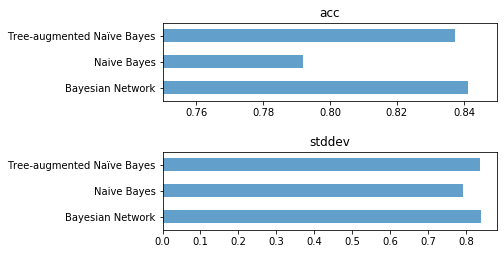

In [77]:
# compare acc and stddev
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1)
fig.tight_layout(pad=3.0)
axes[0].title.set_text('acc')
axes[1].title.set_text('stddev')


acc_data = pd.Series([0.8411, 0.7919, 0.8374], index=['Bayesian Network', 'Naive Bayes', 'Tree-augmented Naïve Bayes'])
acc_data.plot(kind = 'barh', ax=axes[0], alpha=0.7)
axes[0].set_xlim((0.75, 0.85))


stddev_data = pd.Series([0.006208, 0.009104, 0.006946], index=['Bayesian Network', 'Naive Bayes', 'Tree-augmented Naïve Bayes'])
acc_data.plot(kind = 'barh', ax=axes[1], alpha=0.7)

Bayesian Network classifier has the highest accuracy (0.8411) among the tree classifiers and Naïve Bayes classifier has the lowest accuracy (0.7919).

### Bayesian Network
Given the fact that Bayesian Network represents the true relationship between every attribute, all dependencies will be calculated in the algorithm. We use Markov blanket to reduce the computation load and use join() and prob() function in tutorial to generate the joint distribution includes all variables. The complexity is O(N^2).


In [2]:
from IPython.display import Latex

In [2]:
# Using the chain rule for Bayesian networks, we get

In [5]:
Latex(r'$P(bc,e) = \sum P(location)P(age)P(bc|location, age)P(mass|bc, breastdensity)P(ad|bc)\
P(fibrtissuedev|ad)P(mc|bc)P(skinretract|bc, fibrtissuedev)P(nippledischarge|bc, fibrtissuedev)$')

<IPython.core.display.Latex object>

### Naïve Bayes

In Naïve Bayes, we make a strong assumption that every two attributes are independent given the class variable. This assumption uses much less parameters compared with original Bayes Network which makes it faster to get the result. However, because it ignores the connection between attributes, the accuracy is lower. 
In NBC graph, class variable is the only parent and other attributes are children. Then we use this new graph to calculate posterior marginal. The complexity is O(N^2). In prediction part, we sum up all log probability in evidence. The complexity is O(N).

The NBC graph shows bellow

In [6]:
# The chain rule of Bayesian networks
# BC is the class variable
# All other attributes make up the instances

In [7]:
Latex(r"$P(bc,e) = \sum \log(P(bc))log(P(breastdensity|bc))log(P(location|bc))log(P(age|bc))\
log(P(mass|bc))log(P(ad|bc))log(P(mc|bc))log(P(size|bc))log(P(shape|bc))\
log(P(fibrtissuedev|bc))log(P(skinretract|bc))log(P(nippledischarge|bc))log(P(spiculation|bc))log(P(margin|bc))$")

<IPython.core.display.Latex object>

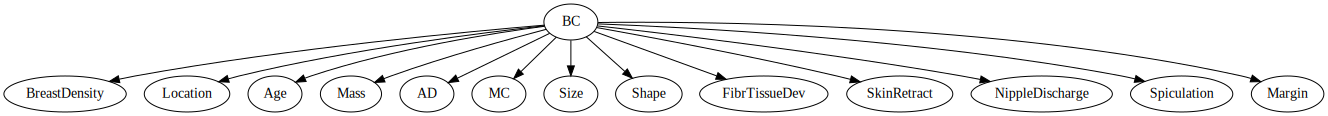

In [79]:
# NBC graph
navie_Bayes_G = Digraph(comment='Naive Bayes Graph')

for v in naive_graph:
    navie_Bayes_G.node(str(v))

for v in naive_graph:
    for w in naive_graph[v]:
        navie_Bayes_G.edge(str(v), str(w))
    
navie_Bayes_G

### Tree-augmented Navie Baye

In fact, most of times we do not have the real graph to show the hidden connection in all attributes. TAN helps us figure out some strong connections in data using mutual information which makes it more reasonable than Naïve Bayes.


First, we calculate MI. The formula is showed as below:

𝐴𝑖 and 𝐴𝑗 represent attributes of the network

C represents the class variable

In [3]:
Latex(r'$MI_D(A_i,A_j|C) = \sum_{a_i,a_j,c} P_D(a_i, a_j, c)\log(\frac{P_D(a_i,a_j|c)}{P_D(a_i|c)P_D(a_j|c)})$')

<IPython.core.display.Latex object>

Then using MI to create the maximum spanning tree, the complexity is O(N^2).

The TAN graph shows bellow:

In [ ]:
# TAN graph
TAN_Bayes_G = Digraph(comment='TAN Graph')

for v in tan_graph:
    TAN_Bayes_G.node(str(v))

for v in tan_graph:
    for w in tan_graph[v]:
        TAN_Bayes_G.edge(str(v), str(w))
    
TAN_Bayes_G

Input the new graph into Bayesian Network to get the result